In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.spatial import distance_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse import csr_matrix

In [2]:
def get_graph(m):
    # Define epsilon.
    eps = (np.log(m) ** (3 / 4)) / np.sqrt(m)
    
    # Generate m random points in R2.
    # X is (m x 2).
    X = np.random.uniform(low=0, high=1, size=(m, 2))
    dists = distance_matrix(X, X)
    
    # Get weight matrix W.
    k_eps = (1 / np.pi) * (1 / eps ** 2)
    W = np.zeros_like(dists)
    W[dists <= eps] = k_eps

    # Get degree matrix.
    D = np.diag(W.sum(axis=1))

    # Get un-normalized GL.
    L = D - W
    
    return X, W, D, L

def prob4():
    # Split L into 3 regions of area 1:
    # [0,1] x [0,2], [1,2] x [0,1], [0,1] x [1,2].
    # Sums to 8192 = 2 ** 13.
    n1, n2, n3 = 2731, 2731, 2730  
    
    # Region 1: [0,1] x [0,2].
    r1 = np.random.uniform([0, 0], [1, 2], size=(n1, 2))

    # Region 2: [1,2] x [0,1].
    r2 = np.random.uniform([1, 0], [2, 1], size=(n2, 2))

    # Region 3: [0,1] x [1,2].
    r3 = np.random.uniform([0, 1], [1, 2], size=(n3, 2))

    # Stack all together.
    X = np.vstack([r1, r2, r3])
    dists = distance_matrix(X, X)

    # Define epsilon.
    m = n1 + n2 + n3
    eps = (np.log(m) ** (3 / 4)) / np.sqrt(m)
    
    # Get weight matrix W.
    k_eps = (1 / np.pi) * (1 / eps ** 2)
    W = np.zeros_like(dists)
    W[dists <= eps] = k_eps

    # Get degree matrix.
    D = np.diag(W.sum(axis=1))

    # Get un-normalized GL.
    L = D - W

    # Turn L into a sparse matrix, and get first 4 eigenvalues.
    L_s = csr_matrix(L)
    eigvals, eigvecs = eigsh(L_s, k=10, which='SM')
    eigvals, eigvecs = eigvals[6:10], eigvecs[:, 6:10]

    # Get psi's.
    psi_list = other_psi(X)

    # Plot eigenvectors.
    fig = plt.figure(figsize=(8, 8))
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], eigvecs[:, i], c=eigvecs[:, i], cmap='viridis', s=15)
        ax.set_title(f"Eigenvector {i+7} (λ={eigvals[i]:.2f})")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.view_init(elev=30, azim=135)
        # Show tick labels with only 2 decimal places
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.show()
    
    # Plot eigenfunctions.
    fig = plt.figure(figsize=(8, 8))
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], psi_list[i], c=psi_list[i], cmap='viridis', s=15)
        ax.set_title("Eigenfunction " + str(i+7))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.view_init(elev=30, azim=135)
        # Show tick labels with only 2 decimal places
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.show()

    # Compute and plot projection error.
    # Make Q and PSI.
    Q = eigvecs.copy()
    PSI = np.column_stack(other_psi(X))

    # Make projectors.
    PQ = Q @ Q.T
    PP = PSI @ PSI.T

    # Compute error.
    error = np.linalg.norm(PQ @ PP - PP @ PQ)
    print("Projection Error:", error)

def psi(X):
    # Here, X is a m x 2 array.
    x, y = X[:, 0], X[:, 1]

    # 1 + cos(pi * x) + cos(pi * y) + cos(pi * x) * cos(pi * y)...
    psi_1 = np.ones_like(x)
    psi_2 = np.cos(np.pi * x)
    psi_3 = np.cos(np.pi * y) 
    psi_4 = np.cos(np.pi * x) * np.cos(np.pi * y)

    # Normalize.
    psi_1 = psi_1 / np.linalg.norm(psi_1)
    psi_2 = psi_2 / np.linalg.norm(psi_2)
    psi_3 = psi_3 / np.linalg.norm(psi_3)
    psi_4 = psi_4 / np.linalg.norm(psi_4)

    return psi_1, psi_2, psi_3, psi_4

def other_psi(X):
    # Here, X is a m x 2 array.
    x, y = X[:, 0], X[:, 1]

    psi_6 = np.cos(2 * np.pi * x) * np.cos(np.pi * y)
    psi_7 = np.cos(np.pi * x) * np.cos(2 * np.pi * y)
    psi_8 = np.cos(2 * np.pi * x) * np.cos(2 * np.pi * y) 
    psi_9 = np.cos(3 * np.pi * x)

    # Normalize.
    psi_6 = psi_6 / np.linalg.norm(psi_6)
    psi_7 = psi_7 / np.linalg.norm(psi_7)
    psi_8 = psi_8 / np.linalg.norm(psi_8)
    psi_9 = psi_9 / np.linalg.norm(psi_9)

    return psi_6, psi_7, psi_8, psi_9

def prob3():
    m_vals = [2 ** 7, 2 ** 8, 2 ** 9, 2 ** 10]

    # Make space to store the errors.
    errors = np.zeros([4, 30])

    # Compute the errors.
    for i, m in enumerate(m_vals):
        for j in range(30):
            # Make Graph / Laplacian.
            X, W, D, L = get_graph(m=m)
    
            # Turn L into a sparse matrix, and get first 4 eigen-values.
            L_s = csr_matrix(L)
            eigvals, eigvecs = eigsh(L_s, k=4, which='SM')

            # Make Q and PSI.
            Q = eigvecs.copy()
            PSI = np.column_stack(psi(X))

            # Make projectors.
            PQ = Q @ Q.T
            PP = PSI @ PSI.T

            # Compute errors.
            errors[i, j] = np.linalg.norm(PQ @ PP - PP @ PQ)

    # Get the average error for each m.
    avg_error = np.mean(errors, axis=1)

    # Make loglog plot.
    fig, ax = plt.subplots()
    plt.loglog(m_vals, avg_error)
    plt.title("Projection Error vs. Graph Size")
    plt.xlabel("m")
    plt.ylabel("Errors")
    plt.show()

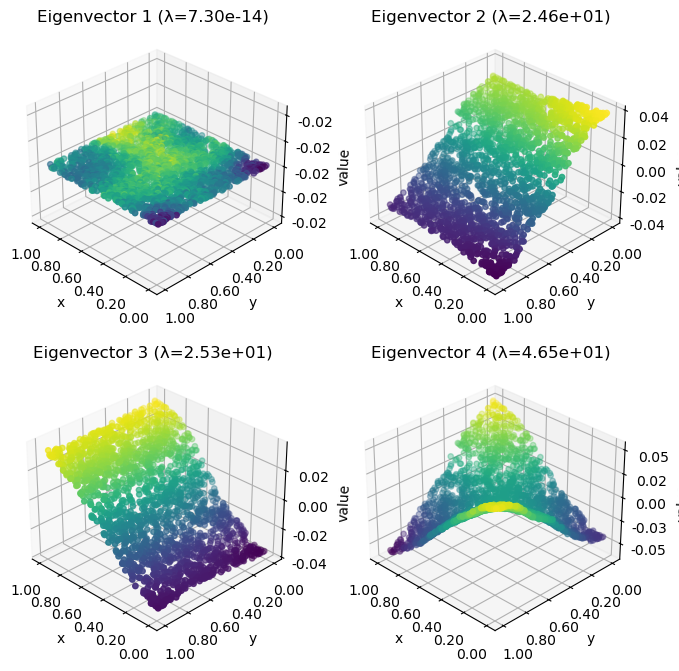

In [3]:
# Part !
X, W, D, L = get_graph(m=2048)

# Turn L into a sparse matrix, and get first 4 eigen-values.
L_s = csr_matrix(L)
eigvals, eigvecs = eigsh(L_s, k=4, which='SM')

# Plot as 3D scatter. [x, y, eigenvector value]
fig = plt.figure(figsize=(8, 8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], eigvecs[:, i], c=eigvecs[:, i], cmap='viridis', s=15)
    ax.set_title(f"Eigenvector {i+1} (λ={eigvals[i]:.2e})")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('value')
    ax.view_init(elev=30, azim=135)

    # Show tick labels with only 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

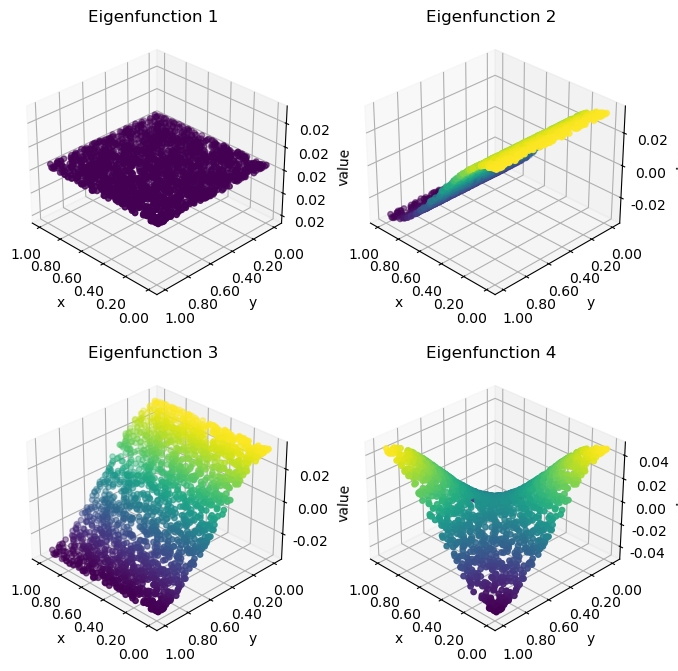

In [4]:
# Part 2.
psi_list = psi(X)

# Plot as 3D scatter. [x, y, psi]
fig = plt.figure(figsize=(8, 8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], psi_list[i], c=psi_list[i], cmap='viridis', s=15)
    ax.set_title("Eigenfunction " + str(i+1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('value')
    ax.view_init(elev=30, azim=135)

    # Show tick labels with only 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

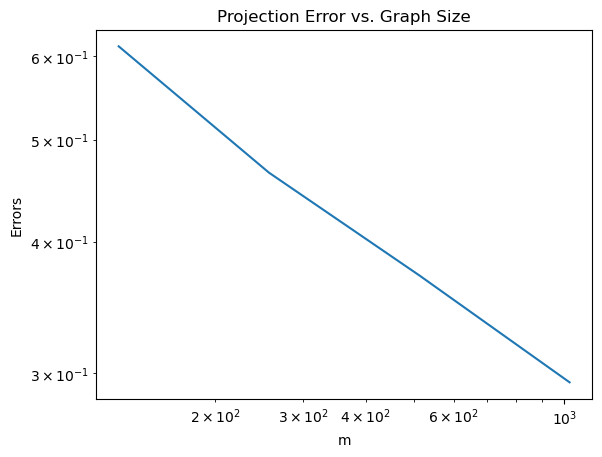

In [5]:
# Problem 3.
prob3()

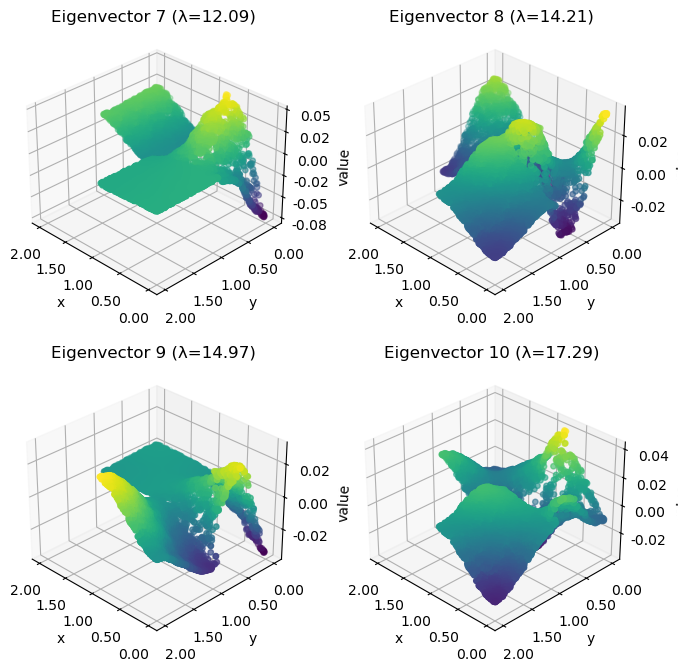

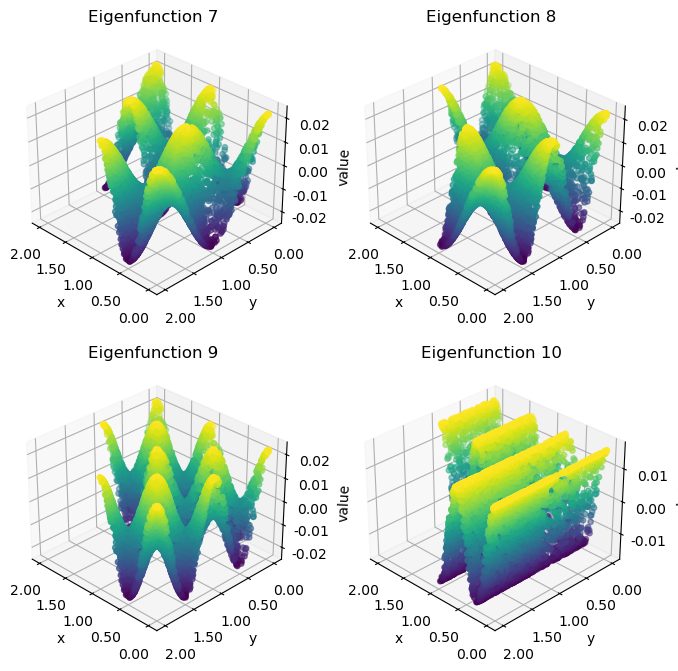

Projection Error: 0.30212303369744103


In [6]:
# Problem 4.
prob4()